In [ ]:
from pathlib import Path
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit,to_timestamp, coalesce, col, date_format, when
from functools import reduce
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dtale
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error




spark = SparkSession.builder.getOrCreate() 


In [89]:
DFP_AQ2_CPM10 = pd.read_csv("DFP_AQ2_CPM10_RR_I.csv", index_col=0, parse_dates=True)
DFP_AQ2_CPM2_5 = pd.read_csv("DFP_AQ2_CPM2_5_RR_I.csv", index_col=0, parse_dates=True)
DFP_AQ1_CPM10 = pd.read_csv("DFP_AQ1_CPM10_RR_I.csv", index_col=0, parse_dates=True)
DFP_AQ1_CPM2_5 = pd.read_csv("DFP_AQ1_CPM2_5_RR_I.csv", index_col=0, parse_dates=True)


In [85]:
def lstm_prediction_improved(df, target_column='pm10', n_steps=24, test_size=0.2, 
                             epochs=100, batch_size=32, plot=False):
    # Extraer la serie
    series = df[target_column].values

    # Crear secuencias
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Índice temporal para test
    time_index = df.index[n_steps:]
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    test_time_index = time_index[split_idx:]
    
    # Definir modelo LSTM mejorado
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    # Entrenar con EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
              validation_split=0.1, callbacks=[early_stop], verbose=1)
    
    # Predecir en test
    predictions = model.predict(X_test)
    
    if plot:
        
        plt.figure(figsize=(12,6))
        plt.plot(test_time_index, y_test, label='Valores Reales', marker='o')
        plt.plot(test_time_index, predictions, label='Predicciones Test', marker='x')
        plt.title('Predicción con LSTM Mejorado')
        plt.xlabel('Tiempo')
        plt.ylabel(target_column)
        plt.legend()
        plt.show()
    
    return model, predictions, y_test, test_time_index


In [79]:

def lstm_prediction_improved2(df, target_column='pm10', n_steps=24, test_size=0.2, 
                             epochs=100, batch_size=32, plot=False):
    """
    Entrena un modelo LSTM apilado para predecir la serie temporal de 'target_column'.
    
    Parámetros:
      - df: DataFrame con la columna objetivo ya normalizada y con índice datetime.
      - target_column: Nombre de la columna a predecir (ej. 'pm10').
      - n_steps: Número de pasos de tiempo (ventana de entrada).
      - test_size: Fracción de datos para el conjunto de test.
      - epochs: Número de épocas de entrenamiento.
      - batch_size: Tamaño del batch para el entrenamiento.
      - plot: Si es True, se grafican los valores reales y las predicciones.
    
    Retorna:
      - model: Modelo LSTM entrenado.
      - predictions: Predicciones sobre el conjunto de test.
      - y_test: Valores reales del conjunto de test.
      - test_time_index: Índice temporal correspondiente al conjunto de test.
    """
    
    # Extraer la serie de interés
    series = df[target_column].values

    # Crear secuencias para el modelo: cada muestra es una ventana de n_steps y el target es el siguiente valor
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    X, y = np.array(X), np.array(y)
    # Ajustar la forma de X a [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Recuperar el índice temporal correspondiente a los targets
    time_index = df.index[n_steps:]
    
    # Dividir en entrenamiento y test
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    test_time_index = time_index[split_idx:]
    
    # Definir modelo LSTM apilado:
    model = Sequential()
    # Primera capa LSTM: devuelve secuencia para alimentar la siguiente capa
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
    model.add(Dropout(0.2))
    # Segunda capa LSTM: también devuelve secuencia para la siguiente capa
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    # Tercera capa LSTM: última capa, no se necesita devolver secuencia
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    # Capa de salida
    model.add(Dense(1))
    
    # Compilar el modelo
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    # Configurar EarlyStopping para evitar sobreentrenamiento
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Entrenar el modelo (se usa validation_split para monitorear la pérdida de validación)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
              validation_split=0.1, callbacks=[early_stop], verbose=1)
    
    # Realizar predicciones en el conjunto de test
    predictions = model.predict(X_test)
    
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(test_time_index, y_test, label='Valores Reales', marker='o')
        plt.plot(test_time_index, predictions, label='Predicciones', marker='x')
        plt.title('Predicción con LSTM Apilado y EarlyStopping')
        plt.xlabel('Tiempo')
        plt.ylabel(target_column)
        plt.legend()
        plt.show()
    
    return model, predictions, y_test, test_time_index


In [90]:
DFP_AQ1_CPM10

,pm2_5,pm10,co,o3,humidity,temperature
time_format,,,,,,
2023-08-01 00:00:00,7.000000,9.000000,14.000000,1.0,60.600000,13.300000
2023-08-01 01:00:00,9.000000,10.000000,13.000000,1.0,63.500000,12.900000
2023-08-01 02:00:00,7.000000,11.000000,13.000000,1.0,64.800000,12.800000
2023-08-01 03:00:00,7.000000,8.000000,12.000000,1.0,66.000000,12.500000
2023-08-01 04:00:00,9.000000,10.000000,13.000000,1.0,67.300000,12.300000
...,...,...,...,...,...,...
2024-03-14 20:00:00,46.038355,59.057658,15.326397,NaN,51.739328,14.239019
2024-03-14 21:00:00,45.560719,58.286993,15.324195,NaN,51.291916,13.924449
2024-03-14 22:00:00,45.084178,57.524021,15.321993,NaN,50.849761,13.616571


Epoch 1/100


/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 182.6646 - val_loss: 87.1492
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 68.8554 - val_loss: 139.5569
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 66.9350 - val_loss: 96.4071
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 60.8260 - val_loss: 75.9385
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 57.3049 - val_loss: 89.7902
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 54.9656 - val_loss: 80.9298
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 53.8064 - val_loss: 99.1403
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 56.0950 - val_loss: 72.3518
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 54.1580 - val_loss: 110.7743
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 52.6950 - val_loss: 92.4141
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 47.8306 - val_loss: 97.5005
Epoch 12/100
107/

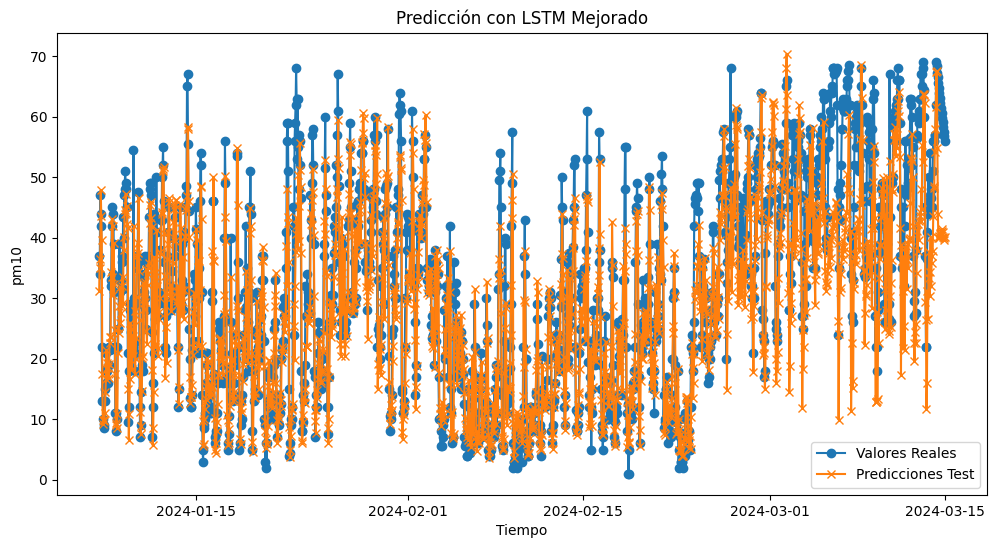

In [91]:
model, preds, y_test, _ = lstm_prediction_improved(DFP_AQ1_CPM10, 
                                                   target_column='pm10', 
                                                   n_steps=24,
                                                   test_size=0.3, 
                                                   epochs=100, 
                                                   batch_size=32, 
                                                   plot=True)

In [92]:
predictions_flat = preds.flatten()  # preds es lo que retorna la función lstm_prediction
y_test_flat = y_test.flatten()        # y_test es lo que retorna la función lstm_prediction

# Calcular R² y MAE
r2 = r2_score(y_test_flat, predictions_flat)
mae = mean_absolute_error(y_test_flat, predictions_flat)

print(f"R²: {r2:.4f}") #0.9
print(f"MAE: {mae:.4f}") 

R²: 0.7075
MAE: 6.8240


In [71]:

y_test_flat = y_test.flatten()
preds_flat = preds.flatten()

mape_manual = np.mean(np.abs((y_test_flat - preds_flat) / y_test_flat))
print(f"MAPE (manual): {mape_manual:.2%}")


MAPE (manual): 28.13%


Epoch 1/100


/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 213.2417 - val_loss: 161.0330
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 101.6288 - val_loss: 95.0381
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 80.8900 - val_loss: 144.4647
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 70.6559 - val_loss: 102.7727
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 66.6394 - val_loss: 87.5539
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 63.3623 - val_loss: 110.4111
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 58.5654 - val_loss: 142.9120
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 55.6708 - val_loss: 80.9871
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 51.6425 - val_loss: 82.4684
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 56.2758 - val_loss: 129.4006
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 55.7894 - val_loss: 86.4285
Epoch 12/100

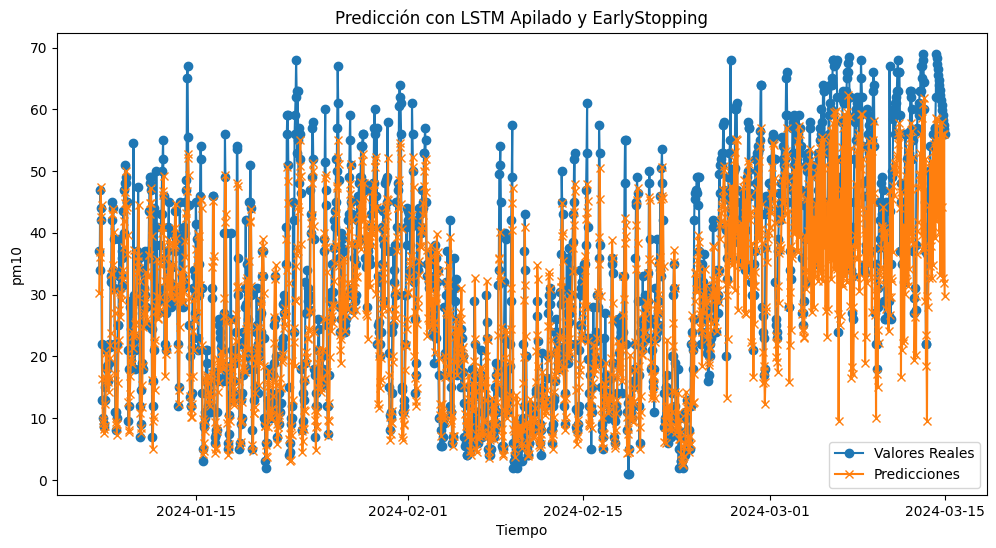

In [80]:
model, preds, y_test, _ = lstm_prediction_improved2(DFP_AQ1_CPM10, 
                                                   target_column='pm10', 
                                                   n_steps=24,
                                                   test_size=0.3, 
                                                   epochs=100, 
                                                   batch_size=32, 
                                                   plot=True)

In [82]:
predictions_flat = preds.flatten()  # preds es lo que retorna la función lstm_prediction
y_test_flat = y_test.flatten()        # y_test es lo que retorna la función lstm_prediction

# Calcular R² y MAE
r2 = r2_score(y_test_flat, predictions_flat)
mae = mean_absolute_error(y_test_flat, predictions_flat)

print(f"R²: {r2:.4f}") #0.9
print(f"MAE: {mae:.4f}") 

R²: 0.6882
MAE: 7.0058


In [41]:
def lstm_prediction_advanced(df, target_column='pm10', n_steps=24, test_size=0.2, 
                             epochs=150, batch_size=32, plot=False):
    # Normalización de datos
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[[target_column]])
    
    # Crear secuencias con datos normalizados
    X, y = [], []
    for i in range(len(scaled_data) - n_steps):
        X.append(scaled_data[i:i+n_steps, 0])
        y.append(scaled_data[i+n_steps, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Índice temporal para test
    time_index = df.index[n_steps:]
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    test_time_index = time_index[split_idx:]
    
    # Definir modelo LSTM más complejo
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    # Optimizador con learning rate scheduler
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Callbacks para mejor entrenamiento
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    
    # Entrenar modelo
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                      validation_split=0.2, callbacks=[early_stop, reduce_lr], verbose=1)
    
    # Predecir en test
    predictions = model.predict(X_test)
    
    # Desnormalizar para obtener valores originales
    predictions_denorm = scaler.inverse_transform(predictions)
    y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Métricas
    
    r2 = r2_score(y_test_denorm, predictions_denorm)
    mae = mean_absolute_error(y_test_denorm, predictions_denorm)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
    
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    if plot:
        
        # Gráfico de predicciones
        plt.figure(figsize=(12,6))
        plt.plot(test_time_index, y_test_denorm, label='Valores Reales', marker='o', markersize=3)
        plt.plot(test_time_index, predictions_denorm, label='Predicciones', marker='x', markersize=3)
        plt.title(f'Predicción con LSTM Avanzado (R²: {r2:.4f}, MAE: {mae:.4f})')
        plt.xlabel('Tiempo')
        plt.ylabel(target_column)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Gráfico de pérdidas durante entrenamiento
        plt.figure(figsize=(10,6))
        plt.plot(history.history['loss'], label='Pérdida (train)')
        plt.plot(history.history['val_loss'], label='Pérdida (validación)')
        plt.title('Curvas de pérdida durante entrenamiento')
        plt.xlabel('Epochs')
        plt.ylabel('Pérdida (MSE)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return model, predictions_denorm, y_test_denorm, test_time_index, history, r2, mae, rmse

# Función para validación cruzada con series temporales
def time_series_cv(df, target_column='pm10', n_steps=24, n_splits=5, epochs=150, batch_size=32):
    
    
    # Preparar datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[[target_column]])
    
    # Crear secuencias
    X, y = [], []
    for i in range(len(scaled_data) - n_steps):
        X.append(scaled_data[i:i+n_steps, 0])
        y.append(scaled_data[i+n_steps, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Inicializar TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Almacenar métricas
    cv_r2_scores = []
    cv_mae_scores = []
    
    # Realizar validación cruzada
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Construir y entrenar modelo
        model = Sequential()
        model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(64, activation='relu', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))
        
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                  validation_split=0.2, callbacks=[early_stop], verbose=0)
        
        # Evaluar modelo
        predictions = model.predict(X_test)
        
        # Desnormalizar
        predictions_denorm = scaler.inverse_transform(predictions)
        y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))
        
        # Calcular métricas
        r2 = r2_score(y_test_denorm, predictions_denorm)
        mae = mean_absolute_error(y_test_denorm, predictions_denorm)
        
        cv_r2_scores.append(r2)
        cv_mae_scores.append(mae)
        
        print(f"Split: R²: {r2:.4f}, MAE: {mae:.4f}")
    
    # Promedios
    avg_r2 = np.mean(cv_r2_scores)
    avg_mae = np.mean(cv_mae_scores)
    
    print(f"\nPromedio CV - R²: {avg_r2:.4f}")
    print(f"Promedio CV - MAE: {avg_mae:.4f}")
    
    return cv_r2_scores, cv_mae_scores

# Función para añadir características adicionales
def add_features(df, target_column='pm10'):
    df_features = df.copy()
    
    # Características temporales
    df_features['hour'] = df_features.index.hour
    df_features['day'] = df_features.index.day
    df_features['month'] = df_features.index.month
    df_features['day_of_week'] = df_features.index.dayofweek
    
    # Características estacionales
    df_features['sin_hour'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['cos_hour'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['sin_day'] = np.sin(2 * np.pi * df_features['day'] / 31)
    df_features['cos_day'] = np.cos(2 * np.pi * df_features['day'] / 31)
    df_features['sin_month'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['cos_month'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
    # Características de tendencia
    df_features[f'{target_column}_rolling_mean_24h'] = df_features[target_column].rolling(window=24, min_periods=1).mean()
    df_features[f'{target_column}_rolling_std_24h'] = df_features[target_column].rolling(window=24, min_periods=1).std()
    df_features[f'{target_column}_lag_1'] = df_features[target_column].shift(1)
    df_features[f'{target_column}_lag_24'] = df_features[target_column].shift(24)
    
    # Llenar valores NaN 
    df_features = df_features.fillna(method='ffill')
    df_features = df_features.fillna(method='bfill')  # Por si hay NaN al principio
    
    return df_features

# Función para modelo multifeature LSTM
def multifeature_lstm_model(df_features, target_column='pm10', feature_columns=None, n_steps=24, test_size=0.2,
                            epochs=150, batch_size=32, plot=False):
    # Si no se especifican columnas de características, usar todas excepto el objetivo
    if feature_columns is None:
        feature_columns = [col for col in df_features.columns if col != target_column]
        
    # Preparar los datos
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    # Escalar datos
    X_scaled = scaler_X.fit_transform(df_features[feature_columns])
    y_scaled = scaler_y.fit_transform(df_features[[target_column]])
    
    # Crear secuencias para modelo multivariable
    X, y = [], []
    for i in range(len(df_features) - n_steps):
        X.append(X_scaled[i:i+n_steps, :])
        y.append(y_scaled[i+n_steps, 0])
    X, y = np.array(X), np.array(y)
    
    # Dividir los datos
    time_index = df_features.index[n_steps:]
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    test_time_index = time_index[split_idx:]
    
    # Modelo LSTM multifeature
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, len(feature_columns))))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    # Compilar y entrenar
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                      validation_split=0.2, callbacks=[early_stop, reduce_lr], verbose=1)
    
    # Predecir
    predictions = model.predict(X_test)
    
    # Desnormalizar predicciones
    predictions_denorm = scaler_y.inverse_transform(predictions)
    y_test_reshaped = y_test.reshape(-1, 1)
    y_test_denorm = scaler_y.inverse_transform(y_test_reshaped)
    
    # Métricas
    r2 = r2_score(y_test_denorm, predictions_denorm)
    mae = mean_absolute_error(y_test_denorm, predictions_denorm)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
    
    print(f"Multifeature R²: {r2:.4f}")
    print(f"Multifeature MAE: {mae:.4f}")
    print(f"Multifeature RMSE: {rmse:.4f}")
    
    if plot:
        plt.figure(figsize=(14,7))
        plt.plot(test_time_index, y_test_denorm, label='Valores Reales', marker='o', markersize=3)
        plt.plot(test_time_index, predictions_denorm, label='Predicciones', marker='x', markersize=3)
        plt.title(f'Predicción Multifeature LSTM (R²: {r2:.4f}, MAE: {mae:.4f})')
        plt.xlabel('Tiempo')
        plt.ylabel(target_column)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Gráfico de pérdidas
        plt.figure(figsize=(10,6))
        plt.plot(history.history['loss'], label='Pérdida (train)')
        plt.plot(history.history['val_loss'], label='Pérdida (validación)')
        plt.title('Curvas de pérdida durante entrenamiento')
        plt.xlabel('Epochs')
        plt.ylabel('Pérdida (MSE)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return model, predictions_denorm, y_test_denorm, test_time_index, r2, mae, rmse

/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - loss: 0.0360 - mae: 0.1438 - val_loss: 0.0435 - val_mae: 0.1540 - learning_rate: 0.0010
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0272 - mae: 0.1257 - val_loss: 0.0338 - val_mae: 0.1331 - learning_rate: 0.0010
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0212 - mae: 0.1076 - val_loss: 0.0306 - val_mae: 0.1298 - learning_rate: 0.0010
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0203 - mae: 0.1065 - val_loss: 0.0316 - val_mae: 0.1306 - learning_rate: 0.0010
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0174 - mae: 0.0994 - val_loss: 0.0319 - val_mae: 0.1315 - learning_rate: 0.0010
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0163 - mae: 0.0958 - val_loss: 0.0315 - val_mae: 0.1377 - learning_rate: 0.0010
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0166 - mae: 0.0967 - val_loss: 0.0430 - val_mae: 0.1511 - learning_rate: 0.0010
Epoch

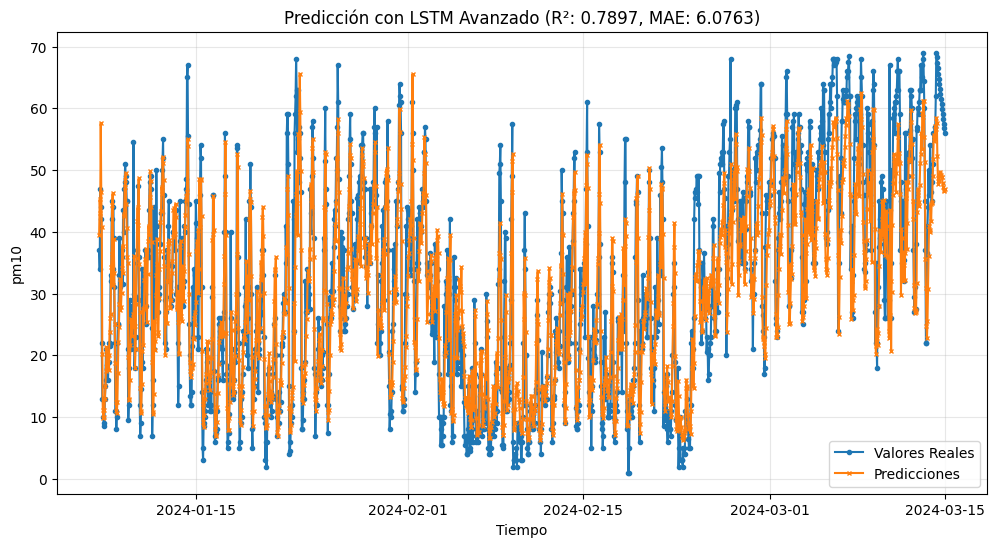

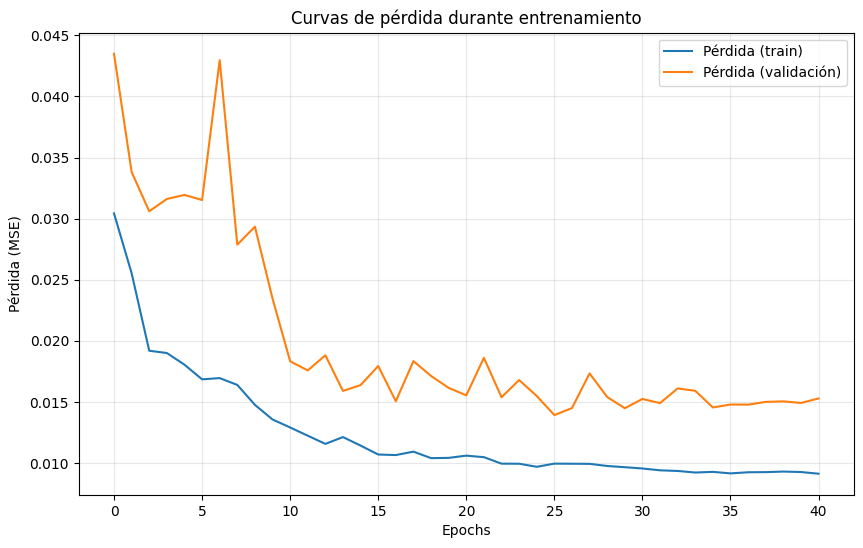

/tmp/ipykernel_188699/1793086575.py:186: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_188699/1793086575.py:187: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0577 - val_loss: 0.0407 - learning_rate: 0.0010
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0350 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0306 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0243 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0260 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 6/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0242 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 7/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0236 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 8/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0214 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 9/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0236 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 10/

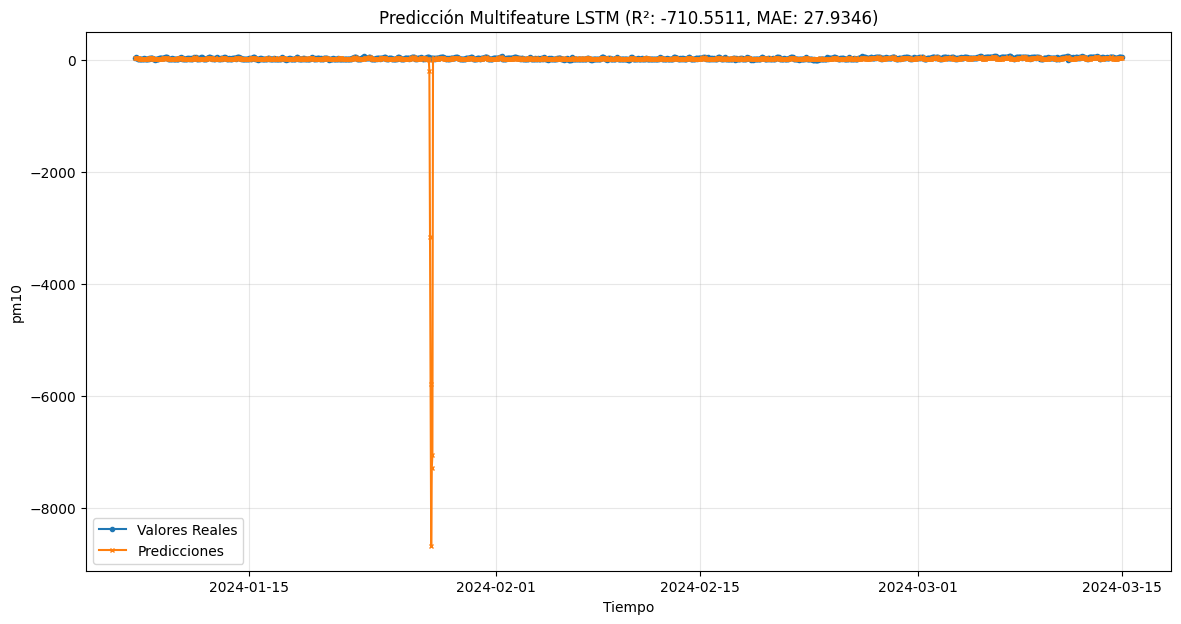

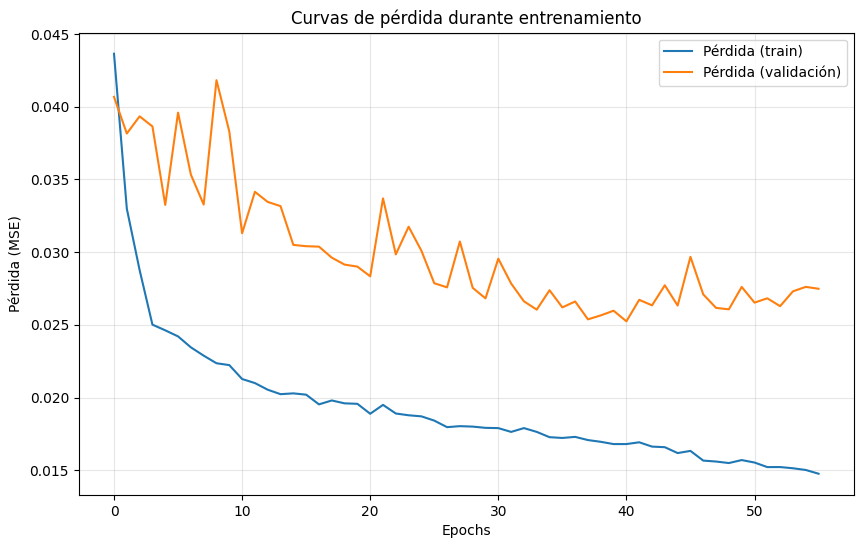

In [93]:
# 1. Primero el modelo básico mejorado
model, preds, y_test, time_idx, history, r2, mae, rmse = lstm_prediction_advanced(
    DFP_AQ1_CPM10, 
    target_column='pm10', 
    n_steps=24,
    test_size=0.3, 
    epochs=100, 
    batch_size=32, 
    plot=True
)

# 2. Luego prueba el enfoque multivariable
# Primero crea las características adicionales
df_features = add_features(DFP_AQ2_CPM10, target_column='pm10')

# Usa todas las características o selecciona las más relevantes
selected_features = ['pm10', 'pm2_5','co','humidity','temperature']

# Entrena el modelo multivariable
model_multi, preds_multi, y_test_multi, time_idx_multi, r2_multi, mae_multi, rmse_multi = multifeature_lstm_model(
    df_features,
    target_column='pm10',
    feature_columns=selected_features,
    n_steps=24,
    test_size=0.3,
    epochs=150,
    batch_size=32,
    plot=True
)